In [2]:
%matplotlib inline

In [3]:
import numpy as np

In [4]:
import matplotlib.image as mpimg

In [5]:
import matplotlib.pyplot as plt

In [6]:
import matplotlib.cm as cm

In [7]:
import png

In [201]:
import scipy.ndimage as ndimage

In [202]:
from scipy.ndimage import filters

In [9]:
height, width = 100,100

In [71]:
# Our starting image
img = ndimage.imread('./eed-noise.png')
# extract red channel
img = img[:,:,0]
height, width = img.shape


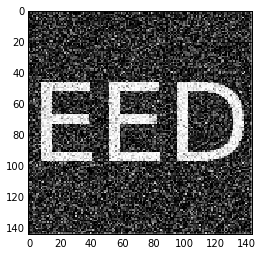

In [104]:
imgplot = plt.imshow(img, cm.Greys_r, interpolation='none', vmin = 0, vmax = 255)

In [231]:
dx, dt = 1,0.1

In [179]:
edge_threshold = 5; lsq = edge_threshold**2

In [227]:
u = np.copy(img).astype(float)

In [163]:
d = np.zeros((height, width))

In [225]:
eps = np.finfo(float).eps # machine epsilon

In [105]:
def show(img):
    plt.imshow(img.reshape(height,width), cm.Greys_r, interpolation='none', vmin = 0, vmax = 255)

In [86]:
def do_step_reflected_boundary_linear_homogeneous(u):
        
    for i, u_x in np.ndenumerate(u):
        if i[0] - 1 < 0:
            left = u[(i[0]+1, i[1])]
        else:
            left = u[(i[0]-1, i[1])]
        if i[0] + 1 > u.shape[1]-1:
            right = u[(i[0]-1, i[1])]
        else:
            right = u[(i[0]+1, i[1])]
        if i[1] - 1 < 0:
            up = u[(i[0], i[1]+1)]
        else:
            up = u[(i[0], i[1]-1)]
        if i[1] + 1 > u.shape[0]-1:
            down = u[(i[0], i[1]-1)]
        else:
            down = u[(i[0], i[1]+1)]
        
        d[i] = up + down + left + right - (4 * u_x)
        d[i] *= dt
    u += d


In [196]:
def do_step_reflected_boundary_nonlinear_isotropic(u):
    pad_u = np.pad(u, 1, 'reflect')
    
    for i, u_i in np.ndenumerate(u):
        # translate to padded co-ordinates
        i0 = i[0]+1
        i1 = i[1]+1
        
        # get values of neighboring pixels for finite differences
        left      = pad_u[i0-1, i1]
        right     = pad_u[i0+1, i1]
        up        = pad_u[i0, i1-1]
        down      = pad_u[i0, i1+1]
        upleft    = pad_u[i0-1, i1-1]
        upright   = pad_u[i0+1, i1-1]
        downleft  = pad_u[i0-1, i1+1]
        downright = pad_u[i0+1, i1+1]

                       
        # approximate first derivatives at half-point between pixels
        d_left  = left  - u_i
        d_right = right - u_i
        d_up    = up    - u_i
        d_down  = down  - u_i
          
        # Perona-Malik diffusion tensor
        g = lambda grad: 1.0/(1.0 + (grad*grad)/lsq)
        g_left, g_right, g_up, g_down = map(g, [d_left, d_right, d_up, d_down])
        
        #d[i] = up + down + left + right - (4 * u_i)
        d[i] = g_left*d_left + g_right*d_right + g_up*d_up + g_down*d_down
        d[i] *= dt
    u += d


In [243]:
def gDerivative(order, x, Gs, scale):
    if order == 0:
        return Gs
    elif order == 1:
        return -x/(scale**2) * Gs
    elif order == 2:
        return (x**2-scale**2)/(scale**4) * Gs
    else:
        raise Exception('only derivatives up to second order are supported')

In [244]:
def gaussian_derivative(u, scale, ox, oy):
    #calculate sample points
    K = np.ceil(3*scale)
    x = np.arange(-K, K+1) # -K, -K+1, ..., 0, ..., K-1, K
    
    #sample gaussian and normalize (zero-order 1D kernel)
    Gs = np.exp( -x**2 / (2*scale**2) )
    Gs = Gs / np.sum(Gs)
    #calculate the derivatives in x and y direction
    Gsx = gDerivative( ox, x, Gs, scale)
    Gsy = gDerivative( oy, x, Gs, scale)
    #do the convolutions
    tmp = filters.convolve1d(u, Gsx, axis=0)
    return filters.convolve1d(tmp, Gsy, axis=1)

In [245]:
def do_step_eed(u):
    # based on https://staff.fnwi.uva.nl/r.vandenboomgaard/nldiffusionweb/nldiffusioncode.pdf
    pad_u = np.pad(u, 1, 'reflect')
    
    # gaussian derivatives
    #Rx = filters.gaussian_filter1d(u, sigma=1, axis=0, order=1)
    #Ry = filters.gaussian_filter1d(u, sigma=1, axis=1, order=1)
    Rx = gaussian_derivative(u, 1, 1, 0)
    Ry = gaussian_derivative(u, 1, 0, 1)
    Rx2 = Rx*Rx
    Ry2 = Ry*Ry
    Rw2 = Rx2+Ry2
    Rw = np.sqrt(Rw2)
    
    # eigenvalues for diffusion tensor
    #c2 = 1.0/(1.0 + (Rw2)/lsq) # Perona-Malik diffusivity across edges
    #c1 = 1                     # full diffusion along edges
    
    c2 = np.exp(-1.0 * (Rw / edge_threshold)**2)
    c1 = 0.2 * c2
    
    # diffusion tensor components
    a = (c1*Rx2 + c2*Ry2) / (Rw2 + eps)
    b = (c2 - c1) * Rx * Ry / (Rw2 + eps)
    c = (c1*Ry2 + c2*Rx2) / (Rw2 + eps)
    
    a = np.pad(a, 1, 'reflect')
    b = np.pad(b, 1, 'reflect')
    c = np.pad(c, 1, 'reflect')
    pad_u = np.pad(u, 1, 'reflect')
    
    #todo: implement this using translation and numpy parallel math
    for i, u_i in np.ndenumerate(u):
        # translate to padded co-ordinates
        i0 = i[0]+1
        i1 = i[1]+1
        
        # get values of neighboring pixels for finite differences
        # notation: first character is variable name. second character
        # is p if x-coord is Plus 1, m for Minus 1. Same for third
        # character but with y-coord. c if no plus or minus for Center.
        umc = pad_u[i0-1, i1]
        upc = pad_u[i0+1, i1]
        ucm = pad_u[i0  , i1-1]
        ucp = pad_u[i0  , i1+1]
        umm = pad_u[i0-1, i1-1]
        upm = pad_u[i0+1, i1-1]
        ump = pad_u[i0-1, i1+1]
        upp = pad_u[i0+1, i1+1]
        ucc = u_i
        
        # Get neighboring diffusion tensor components to use in approximation
        amc = a[i0-1, i1]
        apc = a[i0+1, i1]
        acc = a[i0, i1]
        
        bmc = b[i0-1, i1]
        bpc = b[i0+1, i1]
        bcm = b[i0  , i1-1]
        bcp = b[i0  , i1+1]
        bcc = b[i0, i1]
        
        ccp = c[i0, i1+1]
        ccm = c[i0, i1-1]
        ccc = c[i0, i1]
        
        # stencil method for derivative wrt time
        
        d[i] = (
            -0.25 * (bmc+bcp) * ump +
             0.5  * (ccp+ccc) * ucp +
             0.25 * (bpc+bcp) * upp +
             0.5  * (amc+acc) * umc -
             0.5  * (amc+2*acc+apc+ccm+2*ccc+ccp) * ucc +
             0.5  * (apc+acc) * upc +
             0.25 * (bmc+bcm) * umm +
             0.5  * (ccm+ccc) * ucm +
             0.25 * (bpc+bcm) * upm
        )
        d[i] *= dt
    u += d


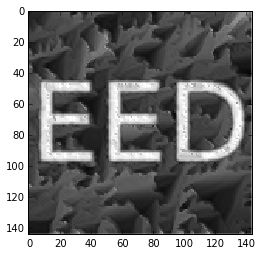

In [246]:
u = np.copy(img).astype(float)
u = ndimage.gaussian_filter(u, sigma=1)
for i in xrange(10*20): do_step_eed(u)
show(u)

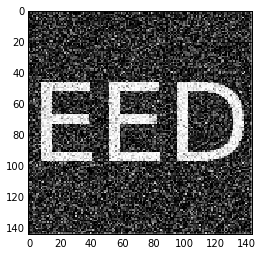

In [228]:
show(u) # Before

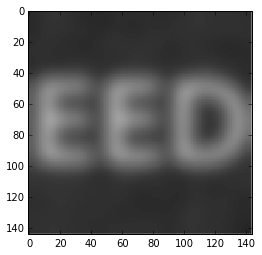

In [189]:
show(u) # After

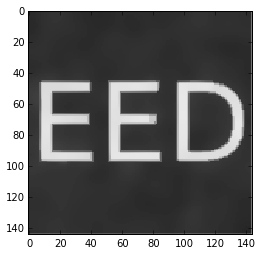

In [200]:
u = np.copy(img).astype(float)
u = ndimage.gaussian_filter(u, sigma=1)
for i in xrange(4*20): do_step_reflected_boundary_nonlinear_isotropic(u)
show(u)

In [188]:
for i in xrange(10*20): do_step_reflected_boundary_linear_homogeneous(u)

In [129]:
np.max(u)

253.64919238916195

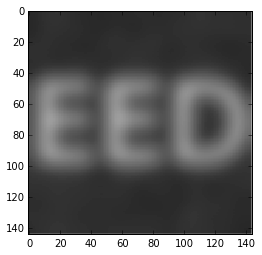

In [190]:
with_blur = ndimage.gaussian_filter(img, sigma=np.sqrt(2*20)); show(with_blur)

In [140]:
((with_blur - u) ** 2).mean(axis=None)

15.146947291544514

In [161]:
A = np.array([1,2,3,4,5,6,7,8,9]).reshape((3,3))
A = np.pad(A, 1, 'reflect')

A[0,2]

5

In [159]:
A

array([[5, 4, 5, 6, 5],
       [2, 1, 2, 3, 2],
       [5, 4, 5, 6, 5],
       [8, 7, 8, 9, 8],
       [5, 4, 5, 6, 5]])

In [224]:
x1 = np.arange(9.0).reshape((3,3)); x1
np.dot(x1, x1)
x1**2

array([[  0.,   1.,   4.],
       [  9.,  16.,  25.],
       [ 36.,  49.,  64.]])

In [208]:
x1

array([[ 0.,  1.,  2.],
       [ 3.,  4.,  5.],
       [ 6.,  7.,  8.]])

In [242]:
np.arange(-3, 3+1
    )

array([-3, -2, -1,  0,  1,  2,  3])